### Small broomrape model for clover

Model adapted from an osu model for small broomrape development in colver. Note that the biofix point is currently arbitory, this needs sorting out before it can be useful

Adapted from:
SMALL BROOMRAPE BIOLOGY AND MANAGEMENT IN THE PACIFIC NORTHWEST
R.D. Lins and J.B. Colquhoun
2008 (osu)

Other useful info:
Small broomrape (Orobanche minor) germination and early development in response to plant species
Weed Science, 52:260–266. 2004
Kyle C. Ross, Jed B. Colquhoun, Carol A. Mallory-Smith

A Predictive Degree-Days Model for Small Broomrape (Orobanche minor) Parasitism in
Red Clover in Oregon
Author(s): Hanan Eizenberg, Jed Colquhoun and Carol Mallory-Smith
Source: Weed Science , Jan. - Feb., 2005, Vol. 53, No. 1 (Jan. - Feb., 2005), pp. 37-40


In [85]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import os as os
import datetime
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower


In [90]:

def loadData():
    #wt = pd.read_csv('LincolnDailyTemps.csv', skiprows=8)
    #wt['DateInd'] = pd.to_datetime(wt['Date(NZST)'], format='%Y%m%d:%H%M')
    #wt = wt[['DateInd', 'Tair(C)']]
    #wt = wt.replace('-', np.nan)
    #wt['Tair(C)'] = wt['Tair(C)'].astype(float)
    
    #wtMeans = wt.set_index('DateInd').groupby(pd.Grouper(freq='1D')).mean()
    #wtMeans['Date'] = wtMeans.index
    
    st = pd.read_csv('winchmoreSoilTemps.csv', skiprows=8)
    st['DateInd'] = pd.to_datetime(st['Date(NZST)'], format='%Y%m%d:%H%M')
    st = st[['DateInd', 'Tearth(C)']]
    st = st.replace('-', np.nan)
    st['Tearth(C)'] = st['Tearth(C)'].astype(float)

    stMeans = st.set_index('DateInd').groupby(pd.Grouper(freq='1D')).mean()
    stMeans['Date'] = stMeans.index
    
    df = stMeans#wtMeans.merge(stMeans, on='Date')
    df = df.loc[~(df['Date'].dt.month.eq(2) & df['Date'].dt.day.eq(29))]
    df['Year'] = pd.DatetimeIndex(df['Date']).year
    df['Month'] = pd.DatetimeIndex(df['Date']).month
    df['Day'] = pd.DatetimeIndex(df['Date']).day

    df['DOY'] = pd.DatetimeIndex(pd.to_datetime(df['Month'].astype(str)+df['Day'].astype(str), format='%m%d')).dayofyear
    df = df[df.Year >=2000]

    return(df)


def createHerbWindow():
    wd = loadData()

    if manStart==True:
        wd = wd[wd['Month']>=startMonth]
        wd.drop(wd[(wd['Month']==startMonth) & (wd['Day']<startDay)].index, inplace=True)
    else:
        wd = wd[wd['Month']>=sowMonth]
        wd.drop(wd[(wd['Month']==sowMonth) & (wd['Day']<sowDay)].index, inplace=True)
        GDDtoStart = GDDtoEmergence + GDDperLeaf*NumLeafAtSBRstart
        wd = wd[wd.groupby(pd.Grouper(key='Date', freq='Y'))['Tair(C)'].cumsum()>=GDDtoStart]
    
    #wd['AirGDD'] = wd.groupby(pd.Grouper(key='Date', freq='Y'))['Tair(C)'].cumsum()
    wd['SoilGDD'] = wd.groupby(pd.Grouper(key='Date', freq='Y'))['Tearth(C)'].cumsum()
    print(wd)
    wd = wd[wd['SoilGDD']< CloverBiomassAffectedGDD + 300]
    
    wdThisYear = wd[wd['Year'] == datetime.datetime.now().year].reset_index()
    wd = wd[wd['Year'] < datetime.datetime.now().year]
    
    
    LTA = wd.groupby('DOY').mean()
    startDOY = LTA.index[0] 
    endDOY = LTA.index[-1] 
    firstMonth = LTA.Month.iloc[0].astype(int)
    lastMonth = LTA.Month.iloc[-1].astype(int)
    
    
    wdThisYear['HerbWindow'] = np.where(((wdThisYear['SoilGDD'] > HerbStartGDD) & (wdThisYear['SoilGDD'] < HerbEndGDD)), True, False)
    wd['HerbWindow'] = np.where(((wd['SoilGDD'] > HerbStartGDD) & (wd['SoilGDD'] < HerbEndGDD)), True, False)
    MeanStart = abs(LTA['SoilGDD'] - HerbStartGDD).idxmin()
    MeanEnd = abs(LTA['SoilGDD'] - HerbEndGDD).idxmin()
    
    Attachment = abs(LTA['SoilGDD'] - AttachGDD).idxmin()    
    Emergence = abs(LTA['SoilGDD'] - EmergenceGDD).idxmin()
    CloverBiomassAffected = abs(LTA['SoilGDD'] - CloverBiomassAffectedGDD).idxmin()
    
    HerbStart = wd[(wd['HerbWindow'] == True) & (wd['SoilGDD'] < (HerbStartGDD + GDDtol))].DOY.max()
    HerbEnd = wd[(wd['HerbWindow'] == True) & (wd['SoilGDD'] > (HerbEndGDD - GDDtol))].DOY.min()

    if wdThisYear.SoilGDD.iloc[-1] > AttachGDD:
        AttachmentThisYear = wdThisYear.iloc[abs(wdThisYear.SoilGDD - AttachGDD).idxmin()].DOY
        plt.hlines(AttachGDD, AttachmentThisYear, startDOY, color='yellow', linestyle='--', label = 'Attachment this Year')
        plt.vlines(AttachmentThisYear,AttachGDD, 0, color='yellow', linestyle='--', label = None)

    if wdThisYear.SoilGDD.iloc[-1] > HerbStartGDD:
        HerbStartThisYear = wdThisYear[(wdThisYear['HerbWindow'] == True) & (wdThisYear['SoilGDD'] < (HerbStartGDD + GDDtol))].DOY.max()
        print('This year, herbicide window opened on the '+str(pd.to_datetime(HerbStartThisYear, format='%j').day) + '/' + str(pd.to_datetime(HerbStartThisYear, format='%j').month))
        plt.hlines(HerbStartGDD, HerbStartThisYear, startDOY, color='blue', linestyle='--', label = 'Herbicide window opened this Year')
        plt.vlines(HerbStartThisYear,HerbStartGDD, 0, color='blue', linestyle='--')

    if wdThisYear.SoilGDD.iloc[-1] > HerbEndGDD:
        HerbEndThisYear = wdThisYear[(wdThisYear['HerbWindow'] == True) & (wdThisYear['SoilGDD'] > (HerbEndGDD - GDDtol))].DOY.min()
        print('This year, herbicide window ended on the '+str(pd.to_datetime(HerbEndThisYear, format='%j').day) + '/' + str(pd.to_datetime(HerbEndThisYear, format='%j').month))
        plt.hlines(HerbEndGDD, HerbEndThisYear, startDOY, color='blue', linestyle='--', label = 'Herbicide window closeded this Year')
        plt.vlines(HerbEndThisYear,HerbEndGDD, 0, color='blue', linestyle='--')

    if wdThisYear.SoilGDD.iloc[-1] > EmergenceGDD:
        EmergenceThisYear = wdThisYear.iloc[abs(wdThisYear.SoilGDD - EmergenceGDD).idxmin()].DOY
        print('This year, emergence on the '+str(pd.to_datetime(EmergenceThisYear, format='%j').day) + '/' + str(pd.to_datetime(EmergenceThisYear, format='%j').month))
        plt.hlines(EmergenceGDD, EmergenceThisYear, startDOY, color='Green', linestyle='--', label = 'Emergence this Year')
        plt.vlines(EmergenceThisYear,EmergenceGDD, 0, color='Green', linestyle='--', label = None)

    if wdThisYear.SoilGDD.iloc[-1] > CloverBiomassAffectedGDD:
        CloverBiomassAffectedThisYear = wdThisYear.iloc[abs(wdThisYear.SoilGDD - CloverBiomassAffectedGDD).idxmin()].DOY
        print('This year, emergence on the '+str(pd.to_datetime(CloverBiomassAffectedThisYear, format='%j').day) + '/' + str(pd.to_datetime(CloverBiomassAffectedThisYear, format='%j').month))
        plt.hlines(CloverBiomassAffectedGDD, CloverBiomassAffectedThisYear, startDOY, color='black', linestyle='--', label = 'Clover Biomass Affected this Year')
        plt.vlines(CloverBiomassAffectedThisYear,CloverBiomassAffectedGDD, 0, color='black', linestyle='--', label = None)


    sb.lineplot(x='DOY', y='SoilGDD', hue = 'Year', data = wd, legend=None, alpha=0.4)
    sb.lineplot(x='DOY', y='SoilGDD', data = wdThisYear, label='This Year', color='red', linestyle='--',  linewidth = 3)
    
    plt.hlines(AttachGDD, Attachment, startDOY, color='yellow')
    plt.vlines(Attachment,AttachGDD, 0, color='yellow', label='Attachment (mean)')

    #plt.hlines(HerbStartGDD, HerbStart, startDOY, color='blue')
    #plt.vlines(HerbStart,HerbStartGDD, 0, color='blue')
    #plt.hlines(HerbEndGDD, HerbEnd, startDOY, color='blue')
    #plt.vlines(HerbEnd,HerbEndGDD, 0, color='blue', label='Herbicide window (extremes)')
    plt.fill_between([HerbStart, HerbEnd], HerbEndGDD, 0, color='blue', alpha=0.2,interpolate=True, label='Herbicide window (extremes)')
    plt.fill_between([startDOY, HerbEnd], HerbEndGDD, HerbStartGDD, color='blue', alpha=0.2,interpolate=True)
    
    plt.hlines(EmergenceGDD, Emergence, startDOY, color='green')
    plt.vlines(Emergence,EmergenceGDD, 0, color='green', label='Emergence (mean)')
    
    plt.hlines(CloverBiomassAffectedGDD, CloverBiomassAffected, startDOY, color='black')
    plt.vlines(CloverBiomassAffected,CloverBiomassAffectedGDD, 0, color='black', label='Biomass affected (mean)')
    
    

    plt.xticks(np.linspace(183,365,7)[:-1], ('1st Jul', '1st Aug', '1st Sep', '1st Oct', '1st Nov', '1st Dec'))
    #monthList = ('Jan','Feb','March','Apr','May','Jun','Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
    #monthList = monthList[firstMonth-1:lastMonth]
    #plt.xticks(np.linspace(startDOY,endDOY,len(monthList)+1)[:-1], monthList)
    plt.xlabel('Date')
    plt.legend()
    
    plt.savefig('WinchmoreSmallBroomrapeGDD.png')

    print('Start of small broomrape accumulation '+str(pd.to_datetime(startDOY, format='%j').day) + '/' + str(pd.to_datetime(startDOY, format='%j').month))
    
    print('Mean herbicide window opening on the '+str(pd.to_datetime(HerbStart, format='%j').day) + '/' + str(pd.to_datetime(HerbStart, format='%j').month))
    print('Mean herbicide window closing is on the '+str(pd.to_datetime(HerbEnd, format='%j').day) + '/' + str(pd.to_datetime(HerbEnd, format='%j').month))
    print('Mean date of attachment is '+str(pd.to_datetime(Attachment, format='%j').day) + '/' + str(pd.to_datetime(Attachment, format='%j').month))
    print('Mean date of emergence is '+str(pd.to_datetime(Emergence, format='%j').day) + '/' + str(pd.to_datetime(Emergence, format='%j').month))
    print('Mean date which clover biomass is affected '+str(pd.to_datetime(CloverBiomassAffected, format='%j').day) + '/' + str(pd.to_datetime(CloverBiomassAffected, format='%j').month))


In [91]:
# base temprature for thermal calculation
Tbase = 0

# start and end of the herbiside window for the small broom rape
HerbStartGDD = 500
HerbEndGDD = 1000

AttachGDD = 400
EmergenceGDD = 1100
CloverBiomassAffectedGDD = 1200
# tolerance to catch the first and last days of the window
GDDtol = 20

#Clover GDD values 
GDDtoEmergence = 102 # value from air, 102, soil is 152
GDDperLeaf = 94

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

            Tearth(C)       Date  Year  Month  Day  DOY      SoilGDD
DateInd                                                             
2017-07-01   7.050000 2017-07-01  2017      7    1  182     7.050000
2017-07-02   6.904167 2017-07-02  2017      7    2  183    13.954167
2017-07-03   6.745833 2017-07-03  2017      7    3  184    20.700000
2017-07-04   5.600000 2017-07-04  2017      7    4  185    26.300000
2017-07-05   4.133333 2017-07-05  2017      7    5  186    30.433333
...               ...        ...   ...    ...  ...  ...          ...
2022-11-03  14.850000 2022-11-03  2022     11    3  307  1053.475000
2022-11-04  14.400000 2022-11-04  2022     11    4  308  1067.875000
2022-11-05  13.316667 2022-11-05  2022     11    5  309  1081.191667
2022-11-06  12.741667 2022-11-06  2022     11    6  310  1093.933333
2022-11-07  12.300000 2022-11-07  2022     11    7  311  1106.233333

[1050 rows x 7 columns]
This year, herbicide window opened on the 12/9
This year, herbicide window end

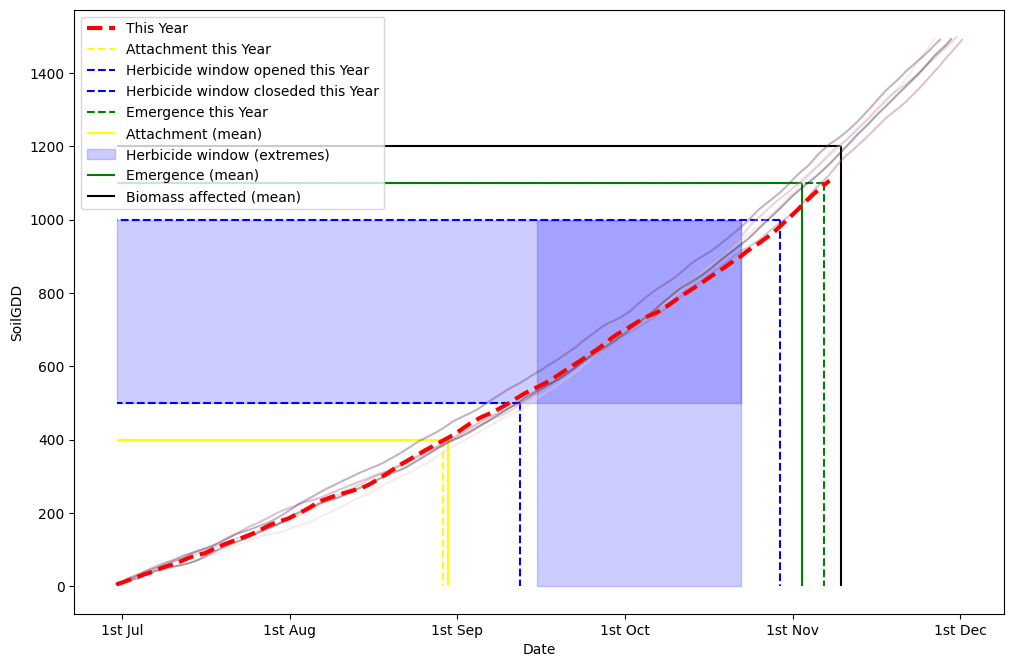

In [92]:
# based on red clover work from Hanan Eizenberg, Jed Colquhoun and Carol Mallory-Smith 2005
# month and day to start thermal accumulation, estimated equivilent of the PNW 1st of Jan. 
# Would be good to look at converting this to a time/thermal time after sowing.
# is there a critical mass of clover root which is required for the broom rape to germinate?

manStart=True

startMonth = 7
startDay = 1

# func call to do the work
createHerbWindow()

In [ ]:
# based on red clover work from Hanan Eizenberg, Jed Colquhoun and Carol Mallory-Smith 2005
# month and day to start thermal accumulation, estimated equivilent of the PNW 1st of Jan. 
# Would be good to look at converting this to a time/thermal time after sowing.
# is there a critical mass of clover root which is required for the broom rape to germinate?

# white clover and red clover have different germination requirments, red, ~66 GDD Tbase 0.6
# white, ~41 GDD Tbase 0.8. Days to 50% emergence dont very much, red 8 to 18, 54GDD between 8 mar and 8 may
# white, 10 to 19, 102GDD

# leaf emergence rate for white clover, phyllochron, 94GDD
# sowing date, GDD to emergence, + 94 * num of leaves to start of small broom rape accumulation
# going to use the same thermal time equation to create the start date, should consider useing its own one.

# for germ need warmish temps with moisture

#manStart=False

#sowMonth = 4
#sowDay = 1

#NumLeafAtSBRstart = 2

# func call to do the work
#createHerbWindow()